In [46]:
import pickle
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

In [3]:
DATA_PATH = "/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD"

In [126]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

In [117]:
s10 = Subject(DATA_PATH, '10')

In [6]:
s10_wrist_data = s10.get_wrist_data()

# Data Preparation

**Wrist - Empatica E4**

ACC: three-axis acceleration (32 Hz)

BVP: blood volume pulse (64 Hz)

EDA: electrodermal activity (4 Hz)

TEMP: skin temperature (4 Hz)

In [7]:
s10_wrist_data

{'ACC': array([[ 107., -105.,  127.],
        [  67.,  -52.,   45.],
        [  26.,   40.,    0.],
        ...,
        [  54.,   23.,   24.],
        [  54.,   23.,   24.],
        [  54.,   23.,   24.]]),
 'BVP': array([[10.17],
        [12.04],
        [13.01],
        ...,
        [57.59],
        [65.93],
        [69.86]]),
 'EDA': array([[0.349215],
        [0.346656],
        [0.350494],
        ...,
        [0.931574],
        [0.932854],
        [0.932854]]),
 'TEMP': array([[33.13],
        [33.16],
        [33.16],
        ...,
        [30.83],
        [30.83],
        [30.83]]),
 'Resp': array([[ 0.21362305],
        [ 0.19226074],
        [ 0.20599365],
        ...,
        [-2.18353271],
        [-2.003479  ],
        [-2.03094482]])}

In [127]:
len(s10.labels)

3847200

In [134]:
bvp_signal = s10_wrist_data['BVP']
eda_signal = s10_wrist_data['EDA']
acc_signal = s10_wrist_data['ACC']
temp_signal = s10_wrist_data['TEMP']
labels = s10.labels

In [9]:
signals, info = nk.eda_process(eda_signal, sampling_rate=4)

nk.eda_plot(signals[:3000], sampling_rate=4)

/opt/homebrew/Caskroom/miniforge/base/envs/sdfw/lib/python3.10/site-packages/neurokit2/signal/signal_filter.py:310: NeuroKitWarning: The sampling rate is too low. Sampling rate must exceed the Nyquist rate to avoid aliasing problem. In this analysis, the sampling rate has to be higher than 6 Hz
  warn(


ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=4 -> fs/2=2.0)

In [19]:
# Turn e4-wrist-data into datafames

eda_df = pd.DataFrame(s10_wrist_data['EDA'], columns=['EDA'])
bvp_df = pd.DataFrame(s10_wrist_data['BVP'], columns=['BVP'])
acc_df = pd.DataFrame(s10_wrist_data['ACC'], columns=['ACC_x', 'ACC_y', 'ACC_z'])
temp_df = pd.DataFrame(s10_wrist_data['TEMP'], columns=['TEMP'])
label_df = pd.DataFrame(s10.labels, columns=['label'])

In [11]:
eda_df.index

RangeIndex(start=0, stop=21984, step=1)

# Data

In [94]:
fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 64}

In [95]:
eda_df.index = [(1 / fs_dict['EDA']) * i for i in range(len(eda_df))]
bvp_df.index = [(1 / fs_dict['BVP']) * i for i in range(len(bvp_df))]
acc_df.index = [(1 / fs_dict['ACC']) * i for i in range(len(acc_df))]
temp_df.index = [(1 / fs_dict['TEMP']) * i for i in range(len(temp_df))]
label_df.index = [(1 / fs_dict['label']) * i for i in range(len(label_df))]

In [96]:
eda_df.index = pd.to_datetime(eda_df.index, unit='s')
bvp_df.index = pd.to_datetime(bvp_df.index, unit='s')
temp_df.index = pd.to_datetime(temp_df.index, unit='s')
acc_df.index = pd.to_datetime(acc_df.index, unit='s')
label_df.index = pd.to_datetime(label_df.index, unit='s')

In [97]:
bvp_df.index

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.015625',
               '1970-01-01 00:00:00.031250', '1970-01-01 00:00:00.046875',
               '1970-01-01 00:00:00.062500', '1970-01-01 00:00:00.078125',
               '1970-01-01 00:00:00.093750', '1970-01-01 00:00:00.109375',
               '1970-01-01 00:00:00.125000', '1970-01-01 00:00:00.140625',
               ...
               '1970-01-01 01:31:35.843750', '1970-01-01 01:31:35.859375',
               '1970-01-01 01:31:35.875000', '1970-01-01 01:31:35.890625',
               '1970-01-01 01:31:35.906250', '1970-01-01 01:31:35.921875',
               '1970-01-01 01:31:35.937500', '1970-01-01 01:31:35.953125',
               '1970-01-01 01:31:35.968750', '1970-01-01 01:31:35.984375'],
              dtype='datetime64[ns]', length=351744, freq=None)

In [98]:
eda_df.index

DatetimeIndex([       '1970-01-01 00:00:00', '1970-01-01 00:00:00.250000',
               '1970-01-01 00:00:00.500000', '1970-01-01 00:00:00.750000',
                      '1970-01-01 00:00:01', '1970-01-01 00:00:01.250000',
               '1970-01-01 00:00:01.500000', '1970-01-01 00:00:01.750000',
                      '1970-01-01 00:00:02', '1970-01-01 00:00:02.250000',
               ...
               '1970-01-01 01:31:33.500000', '1970-01-01 01:31:33.750000',
                      '1970-01-01 01:31:34', '1970-01-01 01:31:34.250000',
               '1970-01-01 01:31:34.500000', '1970-01-01 01:31:34.750000',
                      '1970-01-01 01:31:35', '1970-01-01 01:31:35.250000',
               '1970-01-01 01:31:35.500000', '1970-01-01 01:31:35.750000'],
              dtype='datetime64[ns]', length=21984, freq=None)

In [99]:
# Combined dataframe - not used yet
df = eda_df.join(bvp_df, how='outer')
df = df.join(temp_df, how='outer')
df = df.join(acc_df, how='outer')
df = df.join(label_df, how='outer')
df['label'] = df['label'].fillna(method='bfill')
df.reset_index(drop=True, inplace=True)

In [100]:
len(df[df['label'] == 1])

826000

# Playground

In [27]:
csv = pd.read_csv("/Users/nils/master/Stress-Detection-From-Wearables/data/WESAD/S10/S10_E4_Data/BVP.csv")

Text(0, 0.5, 'BVP')

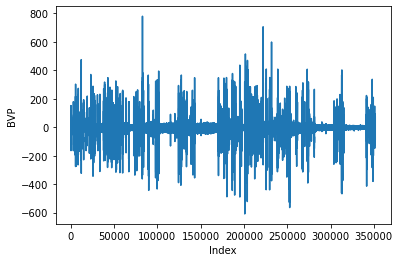

In [59]:
x = bvp_df.index
y = np.array(bvp_df['BVP'])
plt.plot(x, y)
plt.xlabel('Index')
plt.ylabel('BVP')

In [61]:
y_detrend = scipy.signal.detrend(y)

In [64]:
print(y)
print(y_detrend)

[10.17 12.04 13.01 ... 57.59 65.93 69.86]
[10.16143209 12.03143214 13.00143219 ... 57.59766437 65.93766442
 69.86766447]


(0.0, 200.0)

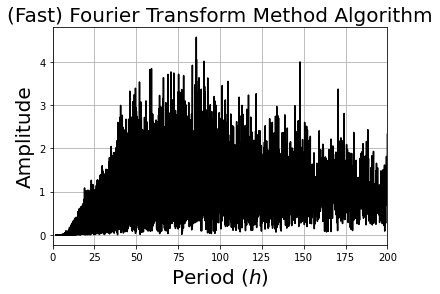

In [66]:
FFT =np.fft.fft(y)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(10**-12, f_nat/2, new_N, endpoint=True)
new_Xph=1.0/(new_X)
FFT_abs=np.abs(FFT)
plt.plot(new_Xph,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_Xph),color='black')
plt.xlabel('Period ($h$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=20)
plt.grid(True)
plt.xlim(0,200)

In [83]:
y[:64]

array([ 1.017e+01,  1.204e+01,  1.301e+01,  1.307e+01,  1.233e+01,
        1.099e+01,  9.380e+00,  7.820e+00,  6.610e+00,  5.910e+00,
        5.730e+00,  5.920e+00,  6.280e+00,  6.560e+00,  6.600e+00,
        6.320e+00,  5.790e+00,  5.110e+00,  4.420e+00,  3.770e+00,
        3.100e+00,  2.270e+00,  1.130e+00, -4.200e-01, -2.400e+00,
       -4.750e+00, -7.420e+00, -1.029e+01, -1.316e+01, -1.572e+01,
       -1.749e+01, -1.798e+01, -1.679e+01, -1.387e+01, -9.590e+00,
       -4.690e+00, -2.000e-02,  3.760e+00,  6.450e+00,  8.340e+00,
        1.000e+01,  1.191e+01,  1.423e+01,  1.668e+01,  1.871e+01,
        1.984e+01,  1.990e+01,  1.921e+01,  1.841e+01,  1.823e+01,
        1.915e+01,  2.130e+01,  2.436e+01,  2.776e+01,  3.088e+01,
        3.330e+01,  3.488e+01,  3.581e+01,  3.642e+01,  3.699e+01,
        3.759e+01,  3.801e+01,  3.787e+01,  3.692e+01])

In [85]:
len(bvp_signal)

351744

In [90]:
print(len(eda_signal))
test = scipy.signal.resample(eda_signal, len(bvp_signal))
len(test)

21984


351744

In [129]:
# Upsampling data to match BVP data sampling rate
eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
acc_upsampled = scipy.signal.resample(acc_signal, len(bvp_signal))


In [144]:
len(labels)/700

5496.0

In [157]:
for i in range(700, len(labels)//700):
    #print((i*700)-700, i*700)
    upper = (i*700)
    lower = (i*700)-700
    min_label = labels[lower:upper].min()
    max_label = labels[lower:upper].max()
    #print(min_label, max_label)
    if min_label != max_label:
        print('not same')
        print(min_label, max_label)
        print((i*700)-700, i*700)

not same
0 1
890400 891100
not same
0 5
938700 939400
not same
0 5
974400 975100
not same
0 3
1116500 1117200
not same
0 3
1376900 1377600
not same
0 7
1414000 1414700
not same
0 7
1453900 1454600
not same
0 4
1570800 1571500
not same
0 4
1849400 1850100
not same
0 2
2234400 2235100
not same
0 2
2741900 2742600
not same
0 6
2942800 2943500
not same
0 6
2974300 2975000
not same
0 4
3443300 3444000
not same
0 4
3721900 3722600


In [178]:
counter_list = []
for i in range(0,len(labels), 700):
    print(i)
    upper = (i*700)
    # lower = (i*700)-700
    #min_label = labels[lower:upper].min()
    #max_label = labels[lower:upper].max()
    #print(min_label, max_label)
    counter_list.append(i)
    #if min_label != max_label:
    #    print('not same')
    #    print(min_label, max_label)
    #    print((i*700)-700, i*700)

0
700
1400
2100
2800
3500
4200
4900
5600
6300
7000
7700
8400
9100
9800
10500
11200
11900
12600
13300
14000
14700
15400
16100
16800
17500
18200
18900
19600
20300
21000
21700
22400
23100
23800
24500
25200
25900
26600
27300
28000
28700
29400
30100
30800
31500
32200
32900
33600
34300
35000
35700
36400
37100
37800
38500
39200
39900
40600
41300
42000
42700
43400
44100
44800
45500
46200
46900
47600
48300
49000
49700
50400
51100
51800
52500
53200
53900
54600
55300
56000
56700
57400
58100
58800
59500
60200
60900
61600
62300
63000
63700
64400
65100
65800
66500
67200
67900
68600
69300
70000
70700
71400
72100
72800
73500
74200
74900
75600
76300
77000
77700
78400
79100
79800
80500
81200
81900
82600
83300
84000
84700
85400
86100
86800
87500
88200
88900
89600
90300
91000
91700
92400
93100
93800
94500
95200
95900
96600
97300
98000
98700
99400
100100
100800
101500
102200
102900
103600
104300
105000
105700
106400
107100
107800
108500
109200
109900
110600
111300
112000
112700
113400
114100
114800
115500


In [180]:
len(counter_list)

5496

### Labels

- 0 = not defined / transient
- 1 = baseline
- 2 = stress
- 3 = amusement
- 4 = meditaiton
- 5/6/7 = should be ignored in this dataset

In [ ]:
# 

In [ ]:
# replace all labels 
df[df['label'] == 1]

In [203]:
df['label'].unique()

array([0, 1, 5, 3, 7, 4, 2, 6], dtype=int32)

In [207]:
unique_list = []
for i in range (0, len(df['label']), 700):
    unique_list.append(df['label'][i:i+700].unique())

In [221]:
for i in unique_list:
    if len(i) != 1:
        print(i)

[0 1]
[1 0]
[0 5]
[5 0]
[0 3]
[3 0]
[0 7]
[7 0]
[0 4]
[4 0]
[0 2]
[2 0]
[0 6]
[6 0]
[0 4]
[4 0]


#### Todos
- Upsample Signals to 64 Hz
- downsample Labels to 64 Hz (Binning?)